# Molecule Classifier

Classify whether an image contains a molecule or not.

**Notes**:

- Gathered the molecule images from the USPTO dataset created for [this paper](https://pubs.acs.org/doi/10.1021/acs.jcim.8b00669). I created plain text using the script `create_text_images.py` found in the same folder in this notebook.
- Tried initially with 100 examples of each class. This resulted in a 22.5% error rate. I'm going to increase the number of images
- Going up to 1000 images dropped the error rate to 0!
- I'm going to look into submitting a PR to add the `timeout` keyword arg to `untar_data` because I had copy the source and manually do that below.

In [1]:
from fastbook import *
from fastai.vision.all import *
from fastai.torch_basics import *


In [4]:
def _try_from_storage(dest, storage):
    "an internal function to create symbolic links for files from `storage` to `dest` if `storage` exists"
    if not storage.exists(): return
    os.makedirs(dest, exist_ok=True)
    for f in storage.glob('*'): os.symlink(f, dest/f.name, target_is_directory=f.is_dir())


        
def download_data(url, fname=None, c_key='archive', force_download=False):
    "Download `url` to `fname`."
    fname = Path(fname or URLs.path(url, c_key=c_key))
    fname.parent.mkdir(parents=True, exist_ok=True)
    if not fname.exists() or force_download: download_url(url, fname, timeout=10, overwrite=force_download)
    return fname

        
def untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=file_extract):
    "Download `url` to `fname` if `dest` doesn't exist, and un-tgz or unzip to folder `dest`."
    default_dest = URLs.path(url, c_key=c_key).with_suffix('')
    dest = default_dest if dest is None else Path(dest)/default_dest.name
    fname = Path(fname or URLs.path(url))
#     if fname.exists() and _get_check(url) and _check_file(fname) != _get_check(url):
#         print("A new version of this dataset is available, downloading...")
#         force_download = True
    if force_download:
        if fname.exists(): os.remove(fname)
        if dest.exists(): shutil.rmtree(dest)
    if not dest.exists(): _try_from_storage(dest, URLs.path(url, c_key='storage').with_suffix(''))
    if not dest.exists():
        fname = download_data(url, fname=fname, c_key=c_key)
#         if _get_check(url) and _check_file(fname) != _get_check(url):
#             print(f"File downloaded is broken. Remove {fname} and try again.")
        extract_func(fname, dest.parent)
        rename_extracted(dest)
    return dest

In [5]:
# Download data
MOLECULES_URL = "https://drive.google.com/uc?export=download&id=1K-0aVGR5WG3v5S63Q2858ZsqxmJJ2Rzp"
path = untar_data(MOLECULES_URL, fname='molecules_dataset.zip')

In [6]:
# Load and split data into training and validation sets
fnames = get_image_files(path)
def label_func(x): return x.parent.name
data = ImageDataLoaders.from_path_func(path, fnames, label_func, valid_pct=0.2, 
                                       seed=100, bs=32, item_tfms=Resize(224))

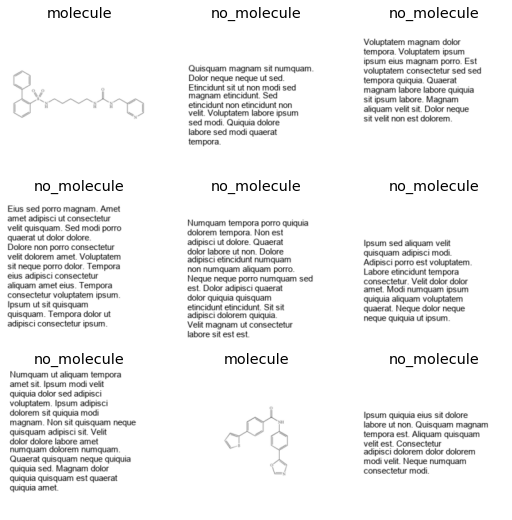

In [7]:
# Show a sample of images
data.show_batch()

In [8]:
# Train classifier
learn = cnn_learner(data, resnet34, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.111182,0.000022,0.000000,02:23


epoch,train_loss,valid_loss,error_rate,time
0,0.018954,0.000281,0.000000,03:21
1,0.006141,0.000005,0.000000,03:24
2,0.002715,0.000000,0.000000,03:27


In [10]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [12]:
img = PILImage.create(uploader.data[0])
is_molecule,_,probs = learn.predict(img)
print(f"Is this a molecule?: {is_molecule}.")
print(f"Probability it's a molecule: {probs[0].item():.6f}")

Is this a molecule?: molecule.
Probability it's a molecule: 1.000000
